# Visualizing Stochastic Gradient Descent (SGD)

## 1. Introduction
In this notebook, we visualize the internal workings of **Stochastic Gradient Descent**.
Unlike Batch Gradient Descent, which produces a smooth trajectory towards the minimum, SGD updates weights using single random data points. This creates a "noisy" path.

We will create three animations:
1.  **Regression Line:** Watching the line fit the data in real-time.
2.  **Contour Plot:** Watching the parameters $(m, b)$ move across the loss landscape.
3.  **Cost Plot:** Watching the error decrease over time.

In [1]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

In [3]:
X,y = make_regression(n_samples=100, n_features=1, n_informative=1, n_targets=1,noise=20,random_state=13)

<IPython.core.display.Javascript object>


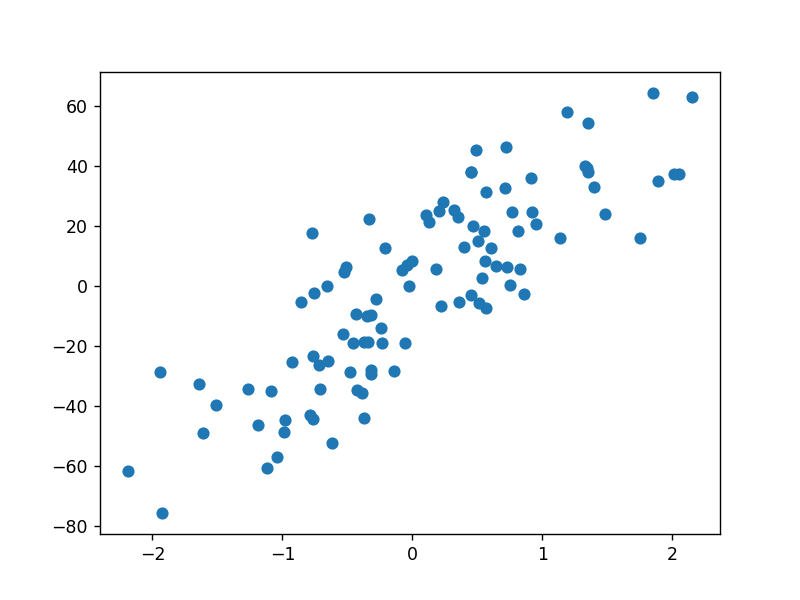

In [4]:
plt.scatter(X,y)

In [5]:
lr = LinearRegression()
lr.fit(X,y)
print(lr.coef_)
print(lr.intercept_)

[27.82809103]
-2.29474455867698


## 2. Implementing SGD with Learning Rate Decay

Here, we implement the training loop.

### Key Features:
* **Stochastic Selection:** inside the loop, we use `np.random.randint` to pick **one** sample at a time.
* **Learning Schedule (Simulated Annealing):** We use a function `learning_rate(t)` that gradually reduces the learning rate.
    * *Start:* High learning rate (makes big jumps to get near the solution).
    * *End:* Low learning rate (makes small adjustments to converge/settle).

In [6]:
import time

b = 150
m = -127.82
all_b = []
all_m = []
all_cost = []
all_lr = []


epochs = 1

start = time.time()

t0,t1 = 5,50
def learning_rate(t):
    return t0/(t + t1)

for i in range(epochs):
    for j in range(X.shape[0]):
        
        lr = learning_rate(i * X.shape[0] + j)
        
        idx = np.random.randint(X.shape[0], size=1)
        
        slope_b = -2 * (y[idx] - (m * X[idx]) -  b)
        slope_m = -2 * (y[idx] - (m * X[idx]) -  b) * X[idx]
        cost = (y[idx] - m * X[idx] -b) ** 2
        
        
        b = b - (lr * slope_b)
        m = m - (lr * slope_m)
        all_b.append(b)
        all_m.append(m)
        all_cost.append(cost)
        all_lr.append(lr)
print("Total time taken",time.time() - start)

Total time taken 0.015251636505126953


In [7]:
len(all_cost)

100

## 3. Animation: The Regression Line
This animation shows how the model's prediction changes after every update.
* **Red Line:** The model's current prediction.
* **Blue Dots:** The actual data.

Notice how the line swings wildly at first (due to the high learning rate and bad initialization) before stabilizing.

<IPython.core.display.Javascript object>


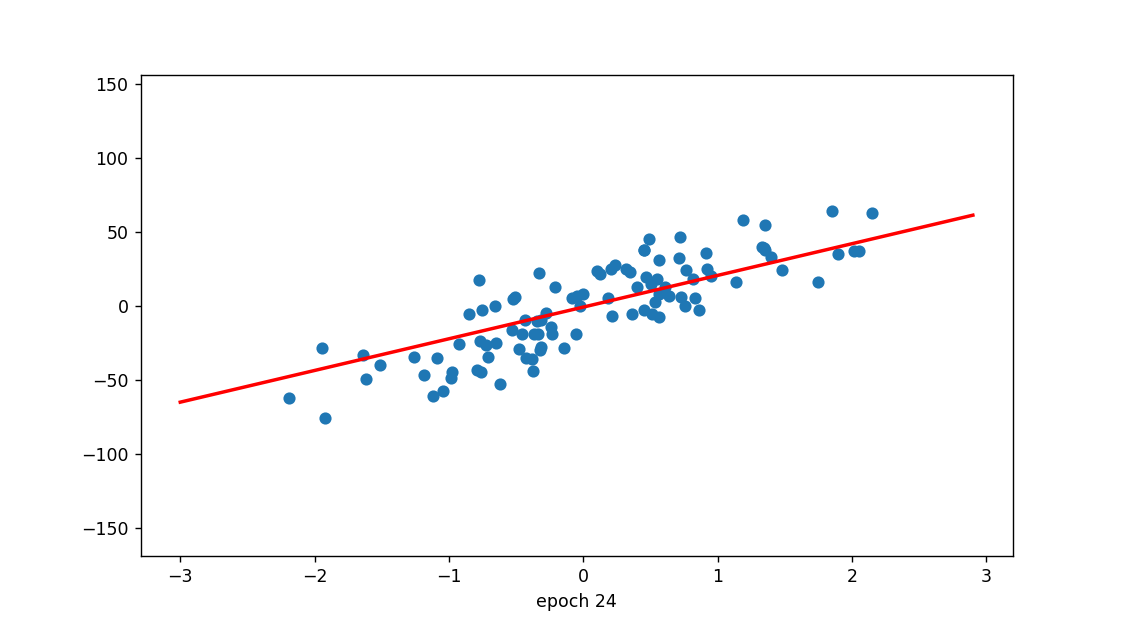

In [17]:
fig, ax = plt.subplots(figsize=(9,5))
#fig.set_tight_layout(True)

x_i = np.arange(-3, 3, 0.1)
y_i = x_i*(-27) -150
ax.scatter(X, y)
line, = ax.plot(x_i, x_i*50 - 4, 'r-', linewidth=2)

def update(i):
    label = 'epoch {0}'.format(i + 1)
    line.set_ydata(x_i*all_m[i] + all_b[i])
    ax.set_xlabel(label)
    # return line, ax

anim = FuncAnimation(fig, update, frames=100, interval=5)

f = r"stochastic_animation_line_plot.gif" 
writergif = animation.PillowWriter(fps=2) 
anim.save(f, writer=writergif)

## 4. Preparing the Loss Landscape
To visualize *how* the algorithm finds the optimal parameters, we need to map out the **Loss Landscape**.
We generate a grid of all possible values for the Slope ($m$) and Intercept ($b$) and calculate the Mean Squared Error (MSE) for each combination.

In [9]:
m_arr = np.linspace(-150, 150, 10)
b_arr = np.linspace(-150, 150, 10)
mGrid, bGrid = np.meshgrid(m_arr,b_arr)

final = np.vstack((mGrid.ravel().reshape(1,100),bGrid.ravel().reshape(1,100))).T

z_arr = []

for i in range(final.shape[0]):
    z_arr.append(np.sum((y - final[i,0]*X.reshape(100) - final[i,1])**2))

z_arr = np.array(z_arr).reshape(10,10)

## 5. Animation: The Trajectory of Descent
This Contour Plot represents the error "bowl".
* **Dark Blue Region:** Low Error (The Target).
* **Yellow/Green Region:** High Error.
* **White Line:** The path taken by our SGD algorithm.

**Observation:** Notice the "zig-zag" motion. Since we calculate gradients on single random points, the direction is never perfectly towards the center, but it averages out to the center over time.

<IPython.core.display.Javascript object>


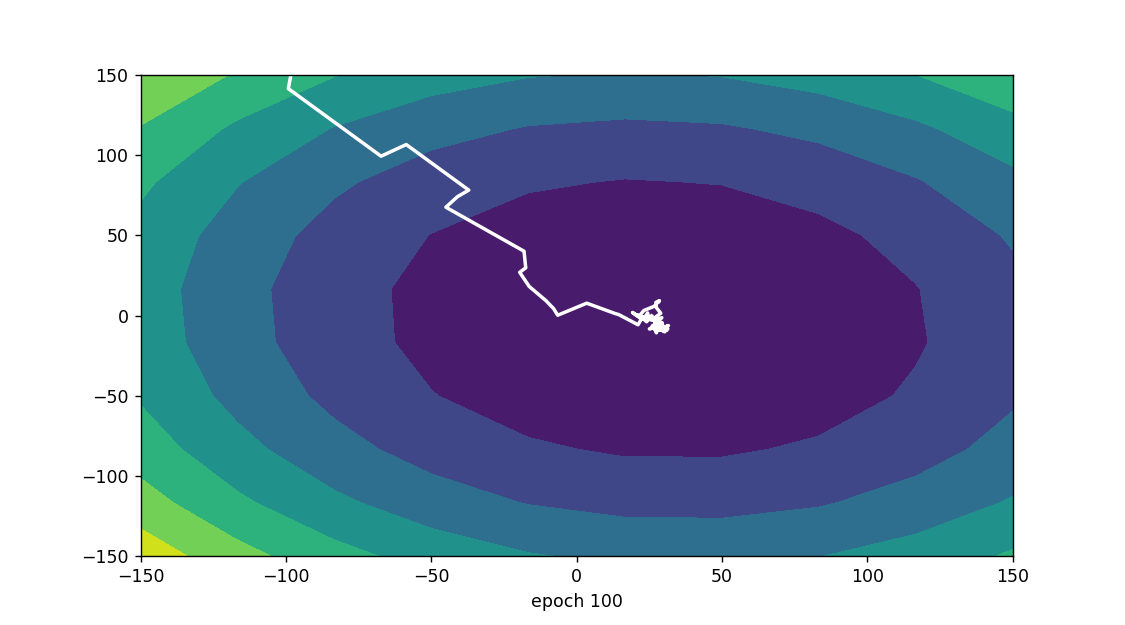

In [18]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

# intercept graph
num_epochs = list(range(0,30))
fig = plt.figure(figsize=(9,5)) 
axis = plt.axes(xlim =(-150, 150), ylim =(-150, 150)) 

axis.contourf(m_arr, b_arr, z_arr)

line, = axis.plot([], [], lw = 2,color='white') 
  
xdata, ydata = [], [] 
  
# animation function 
def animate(i): 
    label = 'epoch {0}'.format(i + 1)
    xdata.append(all_m[i]) 
    ydata.append(all_b[i]) 
    line.set_data(xdata, ydata) 
    axis.set_xlabel(label)
      
    return line, 
  
# calling the animation function     
anim = animation.FuncAnimation(fig, animate, frames = 100,repeat=False, interval = 100)

#f = r"stochastic_animation_contour_plot.gif" 
#writergif = animation.PillowWriter(fps=2) 
#anim.save(f, writer=writergif)

In [11]:
all_b[-1]

array([[-0.14855905]])

In [12]:
all_m[-1]

array([[25.83266575]])

## 6. Animation: Cost vs. Epochs
This plot tracks the Mean Squared Error over time.
* **Sharp Drop:** In the beginning, the model learns very quickly.
* **Fluctuations:** Even at the end, the line isn't perfectly smooth. This noise is characteristic of Stochastic Gradient Descent.

<IPython.core.display.Javascript object>


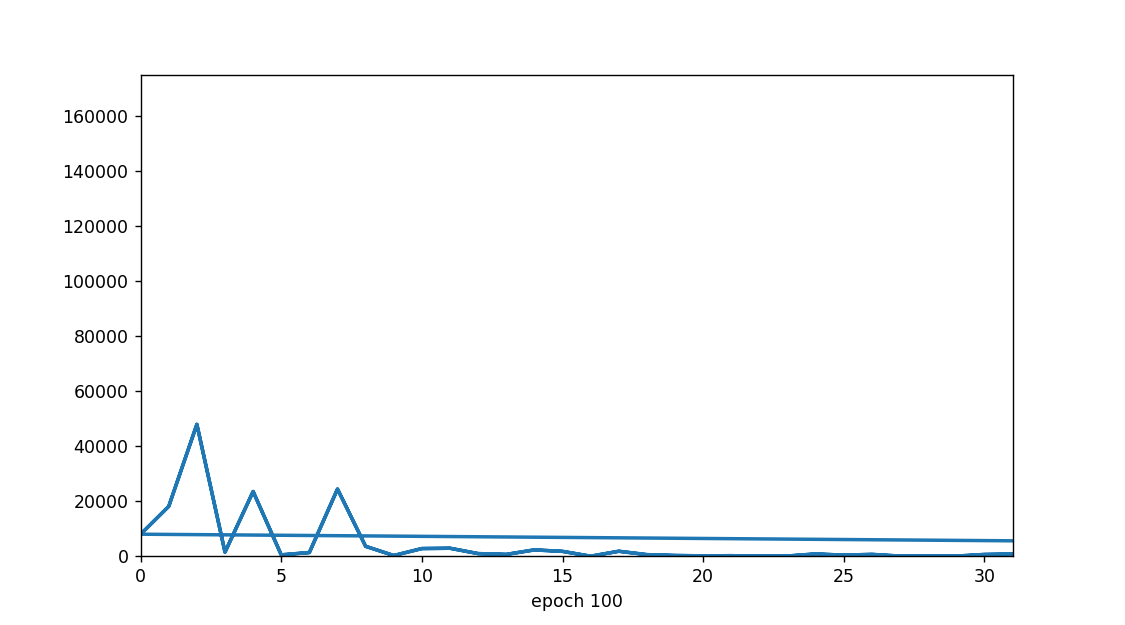

In [20]:
num_epochs = list(range(0,100))
fig = plt.figure(figsize=(9,5)) 
axis = plt.axes(xlim =(0, 31), ylim =(0, 175000)) 
  
line, = axis.plot([], [], lw = 2) 
  
xdata, ydata = [], [] 
  
# animation function 
def animate(i): 
    label = 'epoch {0}'.format(i + 1)
    xdata.append(num_epochs[i]) 
    ydata.append(all_cost[i]) 
    line.set_data(xdata, ydata) 
    axis.set_xlabel(label)
      
    return line, 
  
# calling the animation function     
anim = animation.FuncAnimation(fig, animate, frames = 100,repeat=False, interval = 150)

f = r"stochastic_animation_cost_plot.gif" 
writergif = animation.PillowWriter(fps=2) 
anim.save(f, writer=writergif)

<IPython.core.display.Javascript object>


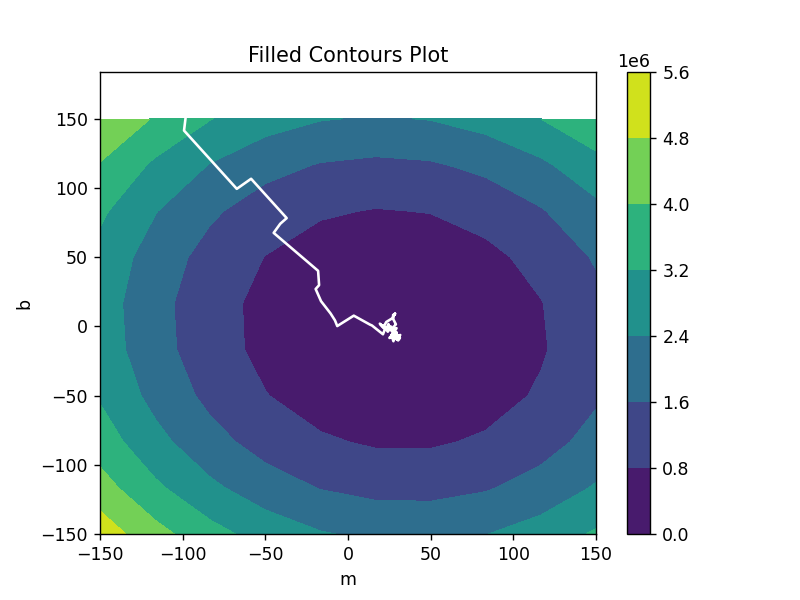

<IPython.core.display.Javascript object>


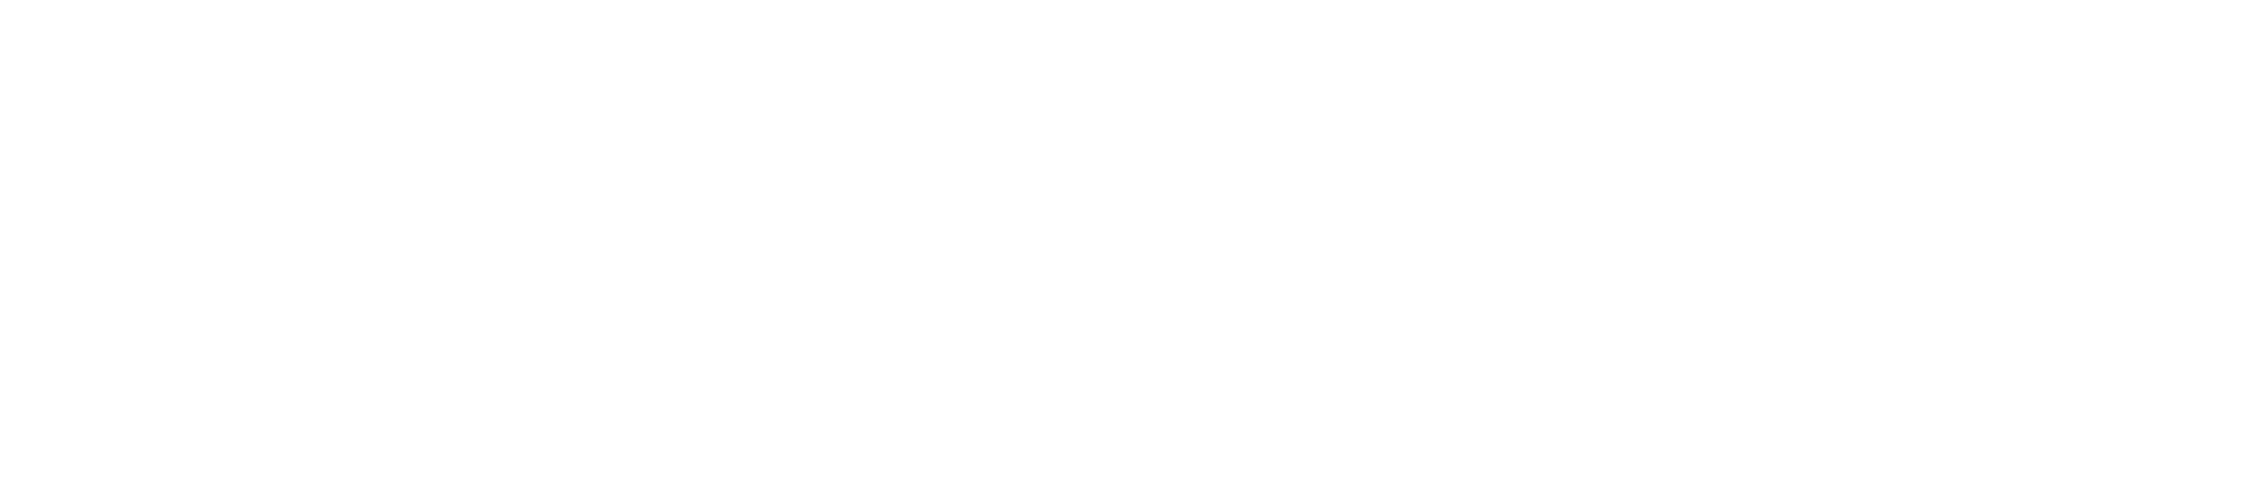

In [21]:
import numpy as np
import matplotlib.pyplot as plt


fig,ax=plt.subplots(1,1)
plt.figure(figsize=(18,4))
cp = ax.contourf(m_arr, b_arr, z_arr)
ax.plot(np.array(all_m).ravel(),np.array(all_b).ravel(),color='white')
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('m')
ax.set_ylabel('b')
plt.show()

In [15]:
all_lr[0]

0.1

In [16]:
all_lr[-1]

0.03355704697986577